[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Pranshu-Bahadur/PackBoost/blob/main/notebooks/numerai_gpu_demo.ipynb)


# PackBoost Numerai GPU Demo

Train PackBoost on Numerai v5.0 with CUDA frontier enabled, bucket eras into user-defined
groups, and monitor per-round train/validation correlation as well as trees-per-second.


In [ ]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"]="1"
os.environ["TORCH_USE_CUDA_DSA"]="1"

In [ ]:
%cd PackBoost

/content/PackBoost


In [ ]:
!PACKBOOST_DISABLE_PACK_PREDICT=0 python examples/hull_benchmark.py  --data datasets/train.csv --era-size 1 --holdout-eras 180 --to-signal-mult 400 --lastn 180  --impute ffill --target-col forward_excess --fx-groups '' --des-off --efb-disable

Data: rows=8,990, base features=94, engineered+base=94, unique raw eras=8990, unique bucketed eras=1
Era mode: DES-OFF (single era) | Target: market_forward_excess_returns
Engineered on groups: []
Impute: ffill
DES-OFF row split: train=8810, test=180 (holdout_frac=0.02)
EFB (PackBoost): DISABLED.
/content/PackBoost/examples/hull_benchmark.py:73: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cors = df.groupby("era", sort=False).apply(
/content/PackBoost/examples/hull_benchmark.py:73: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `includ

In [ ]:
!python examples/hull_benchmark.py  --data datasets/train.csv --era-size 180 --holdout-eras 1 --to-signal-mult 1600 --lastn 180  --impute ffill --target-col forward_excess

/content/PackBoost/examples/hull_benchmark.py:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[c + f"_mom{window_mom}"] = mom.astype(np.float32)
/content/PackBoost/examples/hull_benchmark.py:169: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[c + f"_lag1"] = s.shift(1)
/content/PackBoost/examples/hull_benchmark.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 20.2 MB/s eta 0:00:00


In [ ]:
!PACKBOOST_DISABLE_PACK_PREDICT=0 python examples/synthetic_benchmark.py

Model         Fit (s)   Predict (s)   R^2
--------------------------------------------
PackBoost       5.109        0.049  0.9302
XGBoost         0.843        0.004  0.9619
LightGBM        0.453        0.008  0.9413
CatBoost        1.131        0.002  0.9915


In [ ]:
import packboost._backend as B
for name in ("predict_bins_cuda",
             "predict_pack_cuda",
             "partition_frontier_cuda",
             "find_best_splits_batched_cuda"):
    print(name, type(getattr(B, name, None)))


predict_bins_cuda <class 'builtin_function_or_method'>
predict_pack_cuda <class 'builtin_function_or_method'>
partition_frontier_cuda <class 'builtin_function_or_method'>
find_best_splits_batched_cuda <class 'builtin_function_or_method'>


In [ ]:
%cd PackBoost

/content/PackBoost


In [ ]:
!rm -rf build

In [ ]:
!find packboost -name "_backend*.so" -delete

In [ ]:
!python setup_native.py build_ext --inplace

[setup] compiling CUDA backend: /usr/local/cuda/bin/nvcc -std=c++17 -O3 -Xcompiler -fPIC -c /content/PackBoost/packboost/backends/cuda/frontier_cuda.cu -o /content/PackBoost/build/temp/backend_cuda.o -gencode arch=compute_70,code=sm_70 -gencode arch=compute_70,code=compute_70 -gencode arch=compute_75,code=sm_75 -gencode arch=compute_75,code=compute_75 -gencode arch=compute_80,code=sm_80 -gencode arch=compute_80,code=compute_80 -gencode arch=compute_86,code=sm_86 -gencode arch=compute_86,code=compute_86 -I /usr/local/lib/python3.12/dist-packages/pybind11/include -I /usr/local/lib/python3.12/dist-packages/pybind11/include -I /usr/include/python3.12 -I /usr/local/lib/python3.12/dist-packages/numpy/_core/include -I packboost/backends -DPACKBOOST_ENABLE_CUDA=1
/content/PackBoost/packboost/backends/cuda/frontier_cuda.cu(270): warning #177-D: variable "lane" was declared but never referenced
    const int lane = threadIdx.x & (WARP_SIZE-1);
              ^

Remark: The warnings can be suppres

In [ ]:
!pip install pybind11

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.6/293.6 kB 13.4 MB/s eta 0:00:00


In [ ]:
#@title Install PackBoost and dependencies
REPO_URL = "https://github.com/Pranshu-Bahadur/PackBoost.git"  # change if using a fork

import subprocess, sys, os

if not os.path.exists('PackBoost'):
    subprocess.run(['git', 'clone', REPO_URL, 'PackBoost'], check=True)

os.chdir('PackBoost')

# Build native extensions (enables CUDA frontier when nvcc is present)
subprocess.run([sys.executable, 'setup_native.py', 'build_ext', '--inplace'], check=True)

# Install in editable mode so notebooks can import packboost
subprocess.run([sys.executable, '-m', 'pip', 'install', '-e', '.'], check=True)

print('PackBoost ready.')


PackBoost ready.


## Download Numerai data

This cell pulls the v5.0 training and validation parquet files. Provide keys if you plan to
upload diagnostics later.


In [1]:
%cd PackBoost

/content/PackBoost


In [2]:
!pip install numerapi

In [3]:
from numerapi import NumerAPI
from pathlib import Path
import json
import pandas as pd

DATA_VERSION = 'v5.0'
DATA_DIR = Path('numerai-data')
DATA_DIR.mkdir(exist_ok=True)

napi = NumerAPI()

feature_path = DATA_DIR / 'features.json'
train_path = DATA_DIR / 'train.parquet'
valid_path = DATA_DIR / 'validation.parquet'

if not feature_path.exists():
    napi.download_dataset(f"{DATA_VERSION}/features.json", str(feature_path))
if not train_path.exists():
    napi.download_dataset(f"{DATA_VERSION}/train.parquet", str(train_path))
if not valid_path.exists():
    napi.download_dataset(f"{DATA_VERSION}/validation.parquet", str(valid_path))

with feature_path.open('r', encoding='utf-8') as fh:
    FEATURES = json.load(fh)['feature_sets']['all']


## Preprocess

* Convert targets to float32 and drop rows where the target is NaN.
* Bucket consecutive eras into groups of configurable size (default 64).
* Leave features as int8 bins so we can set `prebinned=True`.


In [4]:
import numpy as np
import torch
import gc

ERA_BUCKET_SIZE = 512  # feel free to tweak

train_df = pd.read_parquet(train_path)
#train_df = train_df.dropna(subset=['target']).reset_index(drop=True)
train_df['era'] = train_df['era'].astype(np.int16)
train_df['era_bucket'] = (train_df['era'] // ERA_BUCKET_SIZE).astype(np.int16)

Xt = train_df[FEATURES].astype(np.int8).values
yt = train_df['target'].astype(np.float32).values
Et = train_df['era_bucket'].to_numpy(np.int16)

valid_df = pd.read_parquet(valid_path)
valid_df = valid_df.dropna(subset=['target'])#.reset_index(drop=True)
valid_df['era'] = valid_df['era'].astype(np.int16)
valid_df['era_bucket'] = (valid_df['era'] // ERA_BUCKET_SIZE).astype(np.int16)

Xv = valid_df[FEATURES].astype(np.int8).values
Yv = valid_df['target'].astype(np.float32).values
Ev = valid_df['era_bucket'].to_numpy(np.int16)

del train_df
gc.collect()


33

## Train PackBoost with CUDA frontier

The training loop logs metrics each round (train/validation correlation and trees per second).


In [5]:
import os
os.environ["PACKBOOST_DISABLE_PACK_PREDICT"] = "0"
os.environ["PACKBOOST_EVAL_EVERY"] = "100"


In [6]:
from packboost.booster import PackBoost
from packboost.config import PackBoostConfig
from packboost import backends
from time import perf_counter
import pandas as pd

print('CUDA backend available:', backends.cuda_available())

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

config = PackBoostConfig(
    pack_size=8,
    max_depth=7,
    learning_rate=0.07,
    lambda_l2=1e-6,
    lambda_dro=0.0,
    direction_weight=0.0,
    min_samples_leaf=20,
    max_bins=5,
    k_cuts=4,
    cut_selection='mass',
    device=str(DEVICE),
    prebinned=True,
    layer_feature_fraction=0.0538,
    random_state=42,
    histogram_mode='subtract'
)

round_logs = []

def log_round(idx: int, metrics: dict[str, float]) -> None:
    print(f"Round {metrics['round']:>3}: train_corr={metrics['train_corr']:+.4f} "
          f"valid_corr={metrics.get('valid_corr', float('nan')):+.4f} "
          f"trees/s={metrics['trees_per_second']:.2f}")
    round_logs.append(metrics)

booster = PackBoost(config)
start = perf_counter()
booster.fit(
    Xt,
    yt,
    None, #Et
    num_rounds=1000,
    eval_sets=[('valid', Xv, Yv, None)],
    round_callback=log_round,
)
elapsed = perf_counter() - start
print(f"Finished training in {elapsed:.2f} seconds")

metrics_df = pd.DataFrame(round_logs)
metrics_df


CUDA backend available: True
Round   1: train_corr=+0.0202 valid_corr=+nan trees/s=22.81
Round   2: train_corr=+0.0238 valid_corr=+nan trees/s=64.90
Round   3: train_corr=+0.0271 valid_corr=+nan trees/s=56.59
Round   4: train_corr=+0.0314 valid_corr=+nan trees/s=52.55
Round   5: train_corr=+0.0326 valid_corr=+nan trees/s=54.61
Round   6: train_corr=+0.0335 valid_corr=+nan trees/s=61.92
Round   7: train_corr=+0.0355 valid_corr=+nan trees/s=57.81
Round   8: train_corr=+0.0372 valid_corr=+nan trees/s=68.64
Round   9: train_corr=+0.0383 valid_corr=+nan trees/s=59.89
Round  10: train_corr=+0.0397 valid_corr=+nan trees/s=54.57
Round  11: train_corr=+0.0403 valid_corr=+nan trees/s=65.68
Round  12: train_corr=+0.0409 valid_corr=+nan trees/s=58.38
Round  13: train_corr=+0.0411 valid_corr=+nan trees/s=67.75
Round  14: train_corr=+0.0419 valid_corr=+nan trees/s=59.42
Round  15: train_corr=+0.0423 valid_corr=+nan trees/s=69.47
Round  16: train_corr=+0.0425 valid_corr=+nan trees/s=52.50
Round  17: 

,round,train_corr,trees_per_second,round_seconds,valid_corr
0,1,0.020237,22.805561,0.350792,NaN
1,2,0.023805,64.895602,0.123275,NaN
2,3,0.027102,56.591467,0.141364,NaN
3,4,0.031407,52.547137,0.152244,NaN
4,5,0.032602,54.613361,0.146484,NaN
...,...,...,...,...,...
995,996,0.166391,51.232018,0.156152,0.028216
996,997,0.166439,63.297129,0.126388,0.028216
997,998,0.166490,57.359727,0.139471,0.028216
998,999,0.166600,48.743751,0.164124,0.028216


## Plot per-round correlation


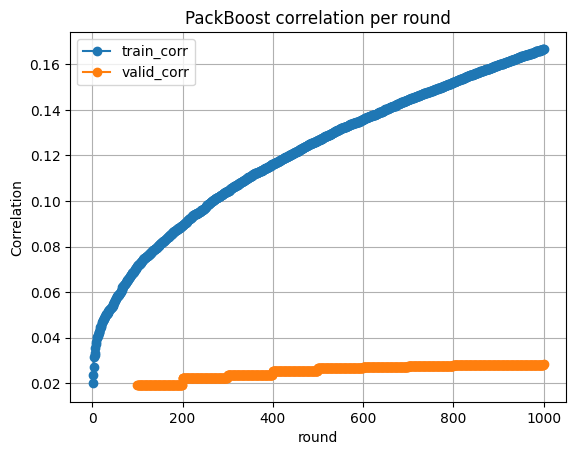

In [7]:
import matplotlib.pyplot as plt
if not metrics_df.empty:
    ax = metrics_df.plot(x='round', y=['train_corr', 'valid_corr'], marker='o')
    ax.set_ylabel('Correlation')
    ax.set_title('PackBoost correlation per round')
    ax.grid(True)
    plt.show()


In [8]:
test = pd.read_parquet(valid_path)

preds = booster.predict(test[FEATURES].astype(np.int8).values)

subm = pd.DataFrame()
subm.index = test.index
subm["prediction"] = preds
subm[['prediction']].rank(pct=True).to_csv("PackBoost1.csv")